In [1]:
# Kaggle Notebook: Fine-Grained Hope Type Classification
!pip install -q transformers

import os
import re
import random
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import List, Dict

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup
)
from sklearn.metrics import classification_report, f1_score

# Config

@dataclass
class Config:
    model_name: str = "xlm-roberta-base"
    max_len: int = 128
    train_batch_size: int = 16      # reduce to 12 if OOM
    valid_batch_size: int = 32
    max_epochs: int = 10
    lr: float = 1.5e-5
    weight_decay: float = 0.01
    warmup_ratio: float = 0.05
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

CFG = Config()
print("Using device:", CFG.device)
if CFG.device == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

# Reproducibility

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CFG.seed)

# Paths 


DATASET_PATH = "/kaggle/input/hope-speech"

TRAIN_PATH = os.path.join(DATASET_PATH, "Finegrained_train_data.csv")
DEV_PATH   = os.path.join(DATASET_PATH, "Finegrained_dev_data.csv")
TEST_PATH  = os.path.join(DATASET_PATH, "Finegrained_test_data_withoutlabel.csv")

print("Train path:", TRAIN_PATH)
print("Dev path:", DEV_PATH)
print("Test path:", TEST_PATH)

# Load Data

train_df = pd.read_csv(TRAIN_PATH)
dev_df   = pd.read_csv(DEV_PATH)
test_df  = pd.read_csv(TEST_PATH)

print("Train columns:", train_df.columns.tolist())
print("Dev columns:", dev_df.columns.tolist())
print("Test columns:", test_df.columns.tolist())

train_df["Label"] = train_df["Label"].astype(str).str.strip().str.lower()
dev_df["Label"]   = dev_df["Label"].astype(str).str.strip().str.lower()

# Label mapping (5 classes)

label_list: List[str] = [
    "optimistic hope",
    "realistic hope",
    "inspiring hope",
    "fading hope",
    "hopelessness",
]
label2id: Dict[str, int] = {lab: i for i, lab in enumerate(label_list)}
id2label: Dict[int, str] = {i: lab for lab, i in label2id.items()}

train_df = train_df[train_df["Label"].isin(label2id.keys())].reset_index(drop=True)
dev_df   = dev_df[dev_df["Label"].isin(label2id.keys())].reset_index(drop=True)

train_df["label_id"] = train_df["Label"].map(label2id)
dev_df["label_id"]   = dev_df["Label"].map(label2id)

print("\nTrain label distribution:\n", train_df["Label"].value_counts())
print("\nDev label distribution:\n", dev_df["Label"].value_counts())

# Light text normalization

def clean_text(t: str) -> str:
    t = str(t)
    t = re.sub(r"\s+", " ", t)                 # collapse spaces
    t = re.sub(r"(.)\1{2,}", r"\1\1", t)       # limit char repetitions
    t = re.sub(r"([!?.,])\1{1,}", r"\1", t)    # limit punct repetitions
    return t.strip()

train_df["clean_text"] = train_df["Text"].astype(str).apply(clean_text)
dev_df["clean_text"]   = dev_df["Text"].astype(str).apply(clean_text)
test_df["clean_text"]  = test_df["Text"].astype(str).apply(clean_text)

# Dataset / Dataloaders

tokenizer = AutoTokenizer.from_pretrained(CFG.model_name)

class HopeDataset(Dataset):
    def __init__(self, texts, labels=None, max_len=64):
        self.texts = texts.tolist()
        self.labels = labels.tolist() if labels is not None else None
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoded = tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
        }
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = HopeDataset(train_df["clean_text"], train_df["label_id"], CFG.max_len)
dev_dataset   = HopeDataset(dev_df["clean_text"], dev_df["label_id"], CFG.max_len)

train_loader = DataLoader(
    train_dataset,
    batch_size=CFG.train_batch_size,
    shuffle=True,
    num_workers=2,
)
dev_loader = DataLoader(
    dev_dataset,
    batch_size=CFG.valid_batch_size,
    shuffle=False,
    num_workers=2,
)

# Model (XLM-R + mean pooling classifier)

class XLMRHopeClassifier(torch.nn.Module):
    def __init__(self, model_name: str, num_labels: int):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size  # 768
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        last_hidden = outputs.last_hidden_state               # (B, L, H)
        mask = attention_mask.unsqueeze(-1).float()           # (B, L, 1)
        summed = (last_hidden * mask).sum(dim=1)              # (B, H)
        denom = mask.sum(dim=1).clamp(min=1e-6)
        pooled = summed / denom                               # mean pooling
        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)
        return logits

model = XLMRHopeClassifier(CFG.model_name, num_labels=len(label_list)).to(CFG.device)

# Loss & Optimizer (clipped 1/freq weights + label smoothing)

label_counts = train_df["label_id"].value_counts().sort_index()
freqs = label_counts.values.astype(float)

raw_w = 1.0 / freqs
raw_w = raw_w / raw_w.mean()          # mean around 1
raw_w = np.clip(raw_w, 0.5, 2.0)      # avoid extreme weights

class_weights_tensor = torch.tensor(raw_w, dtype=torch.float32).to(CFG.device)
print("Class weights:", raw_w)

criterion = torch.nn.CrossEntropyLoss(
    weight=class_weights_tensor,
    label_smoothing=0.03,
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CFG.lr,
    weight_decay=CFG.weight_decay,
)

num_training_steps = CFG.max_epochs * len(train_loader)
num_warmup_steps = int(CFG.warmup_ratio * num_training_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
)

# Train / Eval loops with Early Stopping

def train_one_epoch(epoch):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(CFG.device)
        attention_mask = batch["attention_mask"].to(CFG.device)
        labels = batch["labels"].to(CFG.device)

        optimizer.zero_grad()
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch} - Train loss: {avg_loss:.4f}")

def evaluate():
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dev_loader:
            input_ids = batch["input_ids"].to(CFG.device)
            attention_mask = batch["attention_mask"].to(CFG.device)
            labels = batch["labels"].to(CFG.device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(logits, dim=-1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    print("Dev macro F1:", macro_f1)
    print(classification_report(
        all_labels, all_preds, target_names=label_list, digits=4
    ))
    return macro_f1

best_f1 = 0.0
best_model_path = "/kaggle/working/best_finegrained_xlmr128_ls.pt"
patience = 2
patience_counter = 0

for epoch in range(1, CFG.max_epochs + 1):
    train_one_epoch(epoch)
    macro_f1 = evaluate()
    if macro_f1 > best_f1 + 1e-4:
        best_f1 = macro_f1
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with F1 = {best_f1:.6f}")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement. Patience {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training finished. Best dev macro F1 =", best_f1)

# Inference on test set

model.load_state_dict(torch.load(best_model_path, map_location=CFG.device))
model.to(CFG.device)
model.eval()

print("Test head:")
print(test_df.head())

# Identify ID column
if "ID" in test_df.columns:
    id_col = "ID"
else:
    candidates = [c for c in test_df.columns if c.lower() in ["id", "comment_id", "uid"]]
    assert len(candidates) == 1, "Cannot infer ID column name"
    id_col = candidates[0]
    print("Using ID column:", id_col)

class TestDataset(Dataset):
    def __init__(self, texts, max_len=64):
        self.texts = texts.tolist()
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoded = tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
        }

test_dataset = TestDataset(test_df["clean_text"], CFG.max_len)
test_loader = DataLoader(
    test_dataset,
    batch_size=CFG.valid_batch_size,
    shuffle=False,
    num_workers=2,
)

all_preds = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(CFG.device)
        attention_mask = batch["attention_mask"].to(CFG.device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())

pred_labels = [id2label[i] for i in all_preds]

submission = pd.DataFrame({
    "ID":   test_df[id_col],
    "Text": test_df["Text"],
    "Label": pred_labels,
})

SUBMISSION_PATH = "/kaggle/working/CUET_Synthetica_Tulu_run3.csv"
submission.to_csv(SUBMISSION_PATH, index=False, encoding="utf-8")
print("Saved submission to:", SUBMISSION_PATH)


Using device: cuda
GPU: Tesla T4
Train path: /kaggle/input/hope-speech/Finegrained_train_data.csv
Dev path: /kaggle/input/hope-speech/Finegrained_dev_data.csv
Test path: /kaggle/input/hope-speech/Finegrained_test_data_withoutlabel.csv
Train columns: ['Text', 'Label']
Dev columns: ['Text', 'Label']
Test columns: ['ID', 'Text']

Train label distribution:
 Label
inspiring hope     1129
hopelessness        937
realistic hope      503
optimistic hope     380
fading hope         236
Name: count, dtype: int64

Dev label distribution:
 Label
inspiring hope     242
hopelessness       200
realistic hope     108
optimistic hope     81
fading hope         51
Name: count, dtype: int64


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

XLMRobertaModel LOAD REPORT from: xlm-roberta-base
Key                       | Status     |  | 
--------------------------+------------+--+-
lm_head.dense.bias        | UNEXPECTED |  | 
lm_head.bias              | UNEXPECTED |  | 
lm_head.layer_norm.bias   | UNEXPECTED |  | 
lm_head.layer_norm.weight | UNEXPECTED |  | 
lm_head.dense.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Class weights: [1.21720622 0.91955937 0.5        1.95990833 0.5       ]
Epoch 1 - Train loss: 1.6666
Dev macro F1: 0.08588745814806802
                 precision    recall  f1-score   support

optimistic hope     0.5000    0.0123    0.0241        81
 realistic hope     0.1556    0.3704    0.2192       108
 inspiring hope     0.5000    0.0041    0.0082       242
    fading hope     0.0998    0.8235    0.1780        51
   hopelessness     0.0000    0.0000    0.0000       200

       accuracy                         0.1232       682
      macro avg     0.2511    0.2421    0.0859       682
   weighted avg     0.2689    0.1232    0.0538       682



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


New best model saved with F1 = 0.085887
Epoch 2 - Train loss: 1.5643
Dev macro F1: 0.2833014669638256
                 precision    recall  f1-score   support

optimistic hope     0.2994    0.5802    0.3950        81
 realistic hope     0.1500    0.0278    0.0469       108
 inspiring hope     0.5183    0.7025    0.5965       242
    fading hope     0.1016    0.2549    0.1453        51
   hopelessness     0.5918    0.1450    0.2329       200

       accuracy                         0.3842       682
      macro avg     0.3322    0.3421    0.2833       682
   weighted avg     0.4244    0.3842    0.3452       682

New best model saved with F1 = 0.283301
Epoch 3 - Train loss: 1.4217
Dev macro F1: 0.35995907204186667
                 precision    recall  f1-score   support

optimistic hope     0.3230    0.6420    0.4298        81
 realistic hope     0.2152    0.1574    0.1818       108
 inspiring hope     0.6037    0.6736    0.6367       242
    fading hope     0.1552    0.3529    0.2156    

In [3]:
# ============================================================
# Dev classification report + metrics for best model
# ============================================================
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)

model.load_state_dict(torch.load(best_model_path, map_location=CFG.device))
model.to(CFG.device)
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for batch in dev_loader:
        input_ids = batch["input_ids"].to(CFG.device)
        attention_mask = batch["attention_mask"].to(CFG.device)
        labels = batch["labels"].to(CFG.device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(logits, dim=-1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average="macro")
macro_precision = precision_score(all_labels, all_preds, average="macro")
macro_recall = recall_score(all_labels, all_preds, average="macro")

print(f"Best model - Dev accuracy        : {accuracy:.4f}")
print(f"Best model - Dev macro F1        : {macro_f1:.4f}")
print(f"Best model - Dev macro precision : {macro_precision:.4f}")
print(f"Best model - Dev macro recall    : {macro_recall:.4f}")
print(classification_report(
    all_labels, all_preds, target_names=label_list, digits=4
))


Best model - Dev accuracy        : 0.4897
Best model - Dev macro F1        : 0.4418
Best model - Dev macro precision : 0.4402
Best model - Dev macro recall    : 0.4660
                 precision    recall  f1-score   support

optimistic hope     0.4103    0.5926    0.4848        81
 realistic hope     0.3383    0.4167    0.3734       108
 inspiring hope     0.6681    0.6322    0.6497       242
    fading hope     0.2208    0.3333    0.2656        51
   hopelessness     0.5635    0.3550    0.4356       200

       accuracy                         0.4897       682
      macro avg     0.4402    0.4660    0.4418       682
   weighted avg     0.5211    0.4897    0.4949       682



In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix():
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dev_loader:
            input_ids = batch["input_ids"].to(CFG.device)
            attention_mask = batch["attention_mask"].to(CFG.device)
            labels = batch["labels"].to(CFG.device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(logits, dim=-1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(label_list))))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=label_list,
                yticklabels=label_list,
                cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Dev Set")
    plt.show()


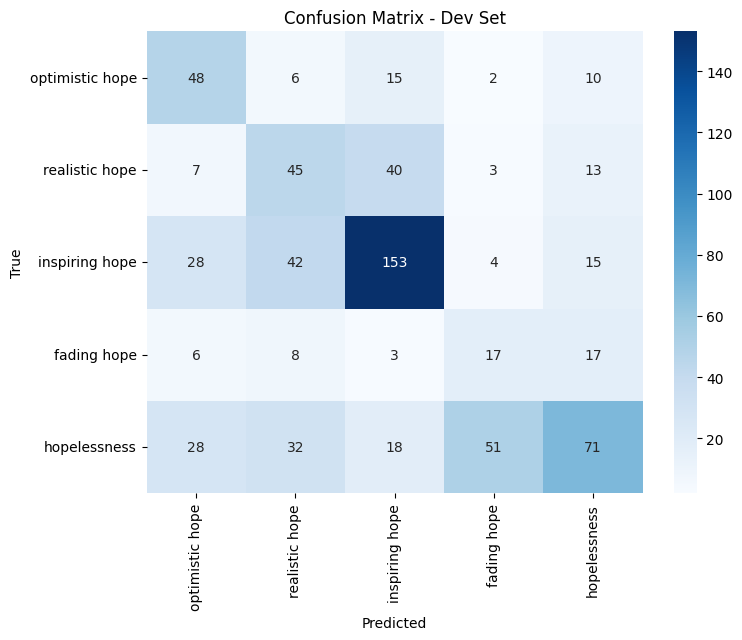

In [5]:
plot_confusion_matrix()

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def save_confusion_matrix(path="/kaggle/working/confusion_matrix_dev.png"):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dev_loader:
            input_ids = batch["input_ids"].to(CFG.device)
            attention_mask = batch["attention_mask"].to(CFG.device)
            labels = batch["labels"].to(CFG.device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(logits, dim=-1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(label_list))))

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt="d",
        xticklabels=label_list,
        yticklabels=label_list,
        cmap="Blues"
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Dev Set")

    plt.tight_layout()
    plt.savefig(path, dpi=300)   # <-- saves to /kaggle/working
    plt.close()
    print(f"Confusion matrix saved to: {path}")

In [7]:
save_confusion_matrix()

Confusion matrix saved to: /kaggle/working/confusion_matrix_dev.png
